# **Analyse des incidents concernant le manque d'arceau de stationnement pour vélos** #

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
import folium
from folium.plugins import HeatMap
import datetime
import os
import smopy

# Get the absolute path to this working directory
cheminAbs = os.getcwd().split(os.path.sep)

# Change the path to the directory CSV
cheminAbs[len(cheminAbs)-1] = "CSV"
chemin = os.path.sep.join(cheminAbs)

# Load the data
df_incidents = pd.read_csv(os.path.join(chemin, "df_incidents.csv"))
df_poi = pd.read_csv(os.path.join(chemin, "df_poi.csv"))
df_incidents = df_incidents[df_incidents['categorie'] == 5]

## Taille de la zone de recherche autour des points d'intêrets

In [80]:
BUFFER_SIZE = 300  # Buffer in meters

## Noms des points d'intérêts sélectionnés

In [81]:
# Noms des points d'intérêt à afficher ex : 'Crèches et Écoles'
noms_pois = 'Crèches et Écoles'

## Nombre de points d'intérêts à afficher sur la carte
### (ces points d'intérêts sont classés par ordre décroissant du nombre de signalements à leur proximité)

In [82]:
# Nombre de points d'intérêt à afficher
nb_poi = 10

# Cartes

## Titre et legende de la carte

In [83]:
title = 'Incidents de type "Accident" à proximité des ' + noms_pois + ' à Paris'

# Légende de la carte
legend_incidents = 'Incidents'
legend_poi = 'Points d\'intérêt'

/var/folders/fn/zw6wxs997ng7zw53fdb1bd4w0000gn/T/ipykernel_14409/2372757782.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_poi['Number of incidents'][j] += 1
/var/folders/fn/zw6wxs997ng7zw53fdb1bd4w0000gn/T/ipykernel_14409/237275778

Lowered zoom level to keep map size reasonable. (z = 13)


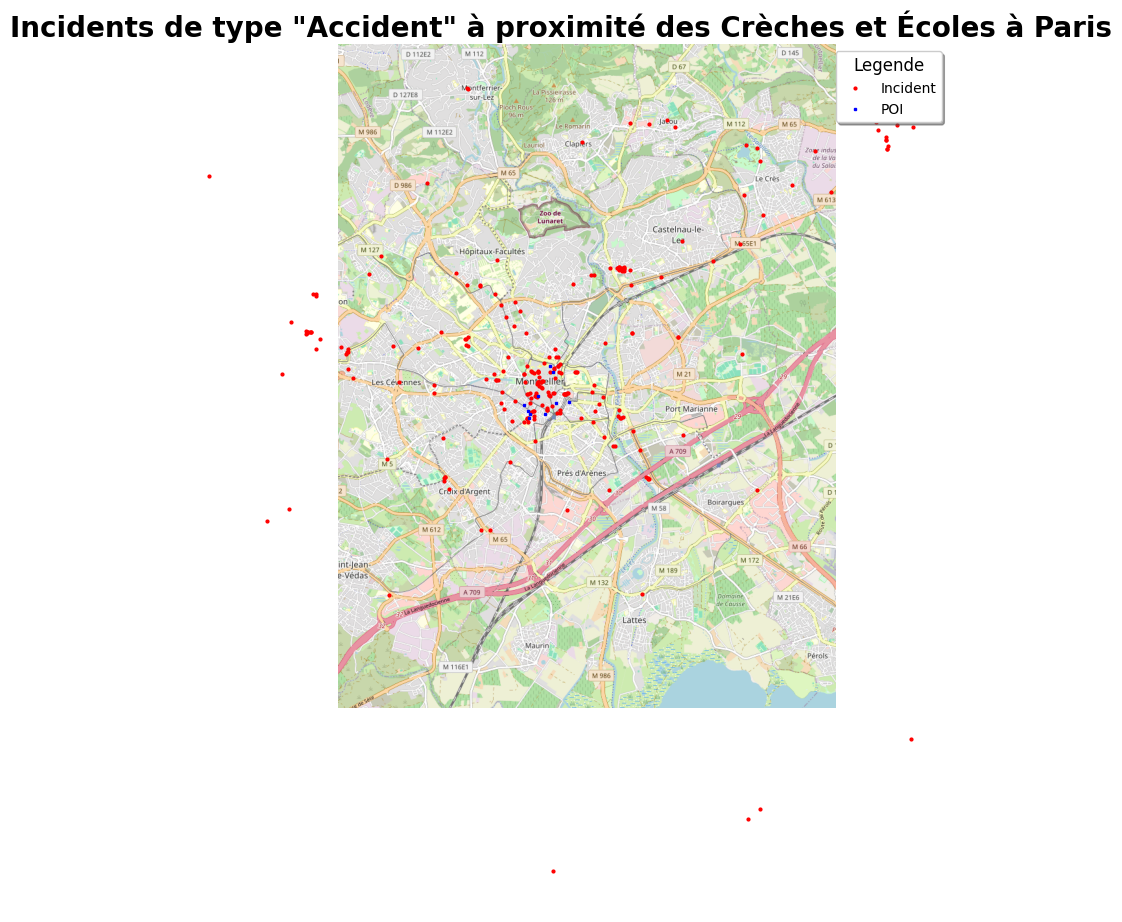

In [84]:
# Creating a column to store the number of incidents
df_poi['Number of incidents'] = 0

# Calculate the distance between each incident and each POI
for i, poi in df_incidents.iterrows():
    for j, incident in df_poi.iterrows():
        distance = geopy.distance.great_circle((poi['latitude'], poi['longitude']),
                                               (incident['latitude'], incident['longitude'])).meters
        if distance < BUFFER_SIZE:
            df_poi['Number of incidents'][j] += 1

# Order the dataframe by the number of incidents in the buffer
df_poi = df_poi.sort_values(by='Number of incidents', ascending=False)

# Define the bounding box based on the center of incidents
lat = df_incidents['latitude'].mean()
lon = df_incidents['longitude'].mean()
delta = 0.05  # Smaller delta for better zooming
box = (lat - delta, lon - delta, lat + delta, lon + delta)

# Create the map with the highest zoom level
map = smopy.Map(box, z=40)  # Using a high zoom level for more detail

# Plot the map
fig, ax = plt.subplots(figsize=(10, 50))  # Horizontal disposition
ax.imshow(map.img)
ax.axis('off')  # Turn off axis graduations

# Function to convert lat/lon to map coordinates and plot the point
def plot_point(lat, lon, color='red', marker='o', label=None):
    x, y = map.to_pixels(lat, lon)
    ax.plot(x, y, marker, color=color, markersize=2, label=label)

# Plot each incident point with a unique label for legend
for i, (lat, lon) in enumerate(df_incidents[['latitude', 'longitude']].values):
    plot_point(lat, lon, label='Incident' if i == 0 else "")

# Plot each POI point with a unique label for legend
for i, (lat, lon, name, number) in enumerate(df_poi[['latitude', 'longitude', 'name', 'Number of incidents']].head(nb_poi).values):
    plot_point(lat, lon, color='blue', marker='s', label='POI' if i == 0 else "")
    x, y = map.to_pixels(lat, lon)
    ax.text(x, y, '', fontsize=10, color='black')

# Add the legend
ax.legend(loc='upper right', fontsize=10 ,title='Légende', title_fontsize='12', shadow=True)

plt.title(title, fontsize=20, fontweight='bold', color='black')
plt.show()

# Cartes Intéractives #

## Titre et légende des cartes intéractives

- ### En rouge : les signalements, en cliquant sur un signalement, on peut voir le détail de l'incident.
- ### En bleu : les points d'intérêts, en cliquant sur un point d'intérêt, on peut voir le nom du POI et le nombre de signalements à proximité.

In [85]:
# Titre de la carte interactive
title_interactive = 'Signalements concernant les stationnements gênants autour de Écoles et Crêches dans la ville de Montpellier'

# Légende de la carte interactive
legend_interactive_incidents = 'Incidents'
legend_interactive_poi = 'Points d\'intérêt'

In [86]:
# Create a new column with the number of incidents in the buffer
df_poi['incidents_in_buffer'] = df_poi.apply(lambda x: sum([geopy.distance.great_circle((x['latitude'], x['longitude']), (lat, lon)).meters < BUFFER_SIZE for lat, lon in zip(df_incidents['latitude'], df_incidents['longitude'])]), axis=1)

# Order the dataframe by the number of incidents in the buffer
df_poi = df_poi.sort_values(by='incidents_in_buffer', ascending=False)

# Create a base map
map_center = [df_incidents['latitude'].mean(), df_incidents['longitude'].mean()]
incident_map = folium.Map(location=map_center, zoom_start=13)

# Add incidents to the map as Markers
for lat, lon, comment in zip(df_incidents['latitude'], df_incidents['longitude'], df_incidents['comment']):
    folium.Marker(
        location=[lat, lon],
        popup=comment,
        icon=folium.Icon(color='red')
    ).add_to(incident_map)

# Add POIs to the map
for lat, lon, name in zip(df_poi['latitude'][:nb_poi], df_poi['longitude'][:nb_poi], df_poi['name'][:nb_poi]):
    folium.Marker(
        location=[lat, lon],
        popup=name,
        icon=folium.Icon(color='blue')
    ).add_to(incident_map)
        
# Add a legend to the map saying that the incidents are red and the POIs are blue
legend_html = """
     <div style=”position: fixed; 
     bottom: 50px; left: 50px; width: 100px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     “>&nbsp; Incidents in red <br>
     &nbsp; POIs in blue
      </div>
     """

# Display the map
incident_map

In [87]:
# Heatmap
# Create a base map
incident_heatmap = folium.Map(location=map_center, zoom_start=13)

# Add incidents to the map as HeatMap
HeatMap(data=df_incidents[['latitude', 'longitude']], radius=10).add_to(incident_heatmap)

# Add POIs to the map
for lat, lon, name in zip(df_poi['latitude'][:nb_poi], df_poi['longitude'][:nb_poi], df_poi['name'][:nb_poi]):
    folium.Marker(
        location=[lat, lon],
        popup=name,
        icon=folium.Icon(color='blue')
    ).add_to(incident_heatmap)

# Add a title
title_html = f'''
             <h3 align="center" style="font-size:20px"><b></b>{title_interactive}</h3>
             '''
incident_heatmap.get_root().html.add_child(folium.Element(title_html))

# Add a legend to the map saying that the incidents are red and the POIs are blue
legend_html = """
     <div style=”position: fixed; 
     bottom: 50px; left: 50px; width: 100px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     “>&nbsp; Incidents in red <br>
     &nbsp; POIs in blue
      </div>
     """

incident_heatmap

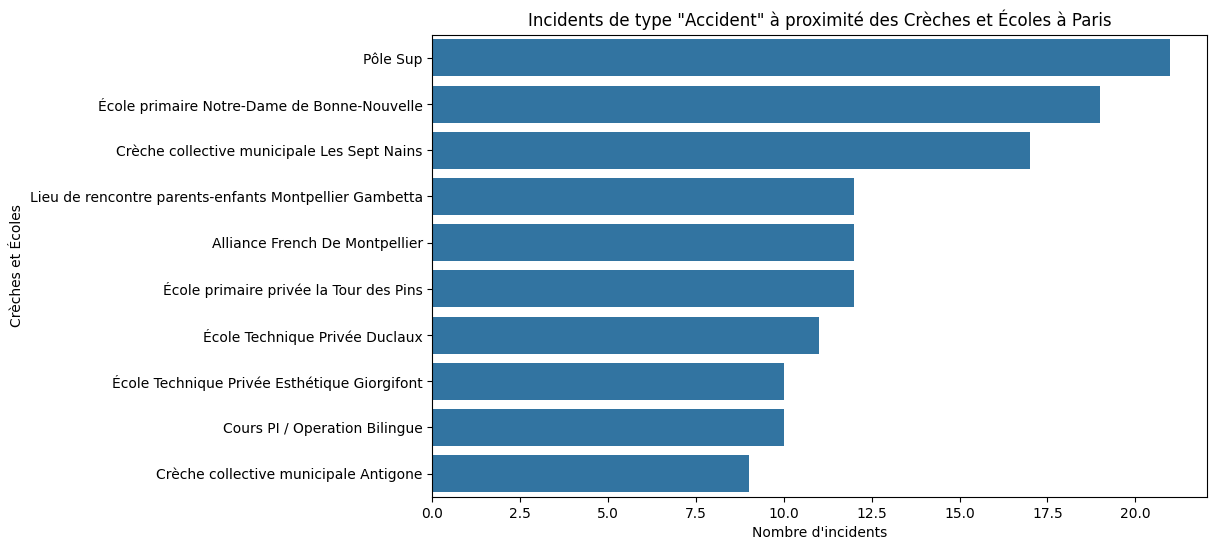

In [88]:
#Plot the number of incidents in the buffer for each POI
plt.figure(figsize=(10, 6))
sns.barplot(x='incidents_in_buffer', y='name', data=df_poi.head(10))
plt.title(f'{title}')
plt.xlabel('Nombre d\'incidents')
plt.ylabel(f'{noms_pois}')
plt.show()

## Les commentaires les plus récurrents

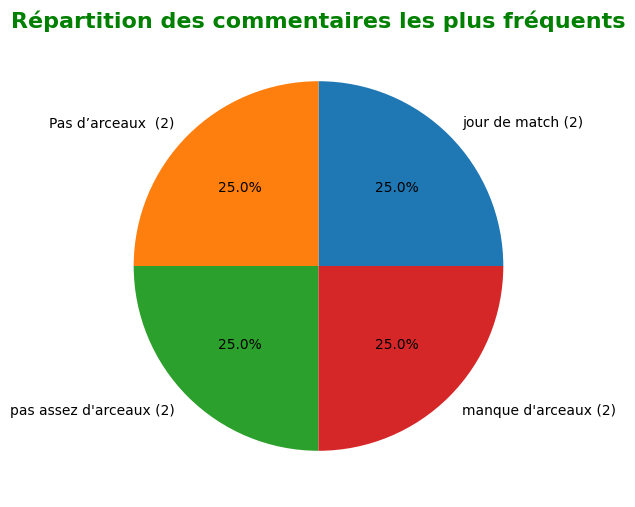

In [89]:
# Finding the most frequent comments with the address of the incident
commentaires = df_incidents['comment'].value_counts()
commentaires = commentaires[commentaires > 1]
commentaires = commentaires.to_frame().reset_index()
commentaires.columns = ['Commentaire', 'Nombre']
commentaires['Adresse'] = None

for i, row in commentaires.iterrows():
    commentaires.at[i, 'Adresse'] = df_incidents[df_incidents['comment'] == row['Commentaire']]['address'].values[0]

# Display the 10 most frequent comments with their addresses
top_commentaires = commentaires.head(10)

# Create labels for the pie chart with comment and count
labels = [f"{row['Commentaire']} ({row['Nombre']})" for _, row in top_commentaires.iterrows()]

# Pie chart of the most frequent comments
plt.figure(figsize=(10, 6))
plt.pie(top_commentaires['Nombre'], labels=labels, autopct='%1.1f%%')
plt.title('Répartition des commentaires les plus fréquents', fontsize=16, fontweight='bold', color='green') 
plt.show()